## Importing necessary libraries

In [1]:
# Data manipulation & handling libraries
import pandas as pd 
import numpy as np 

# Data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sci

# VIF library
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data preprocessing libraries
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.decomposition import PCA

# Model selection libraries
from sklearn.model_selection import train_test_split,cross_val_score

# Model evaluation libraries
from sklearn.metrics import r2_score,mean_squared_error

# Machine learning libraries
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor
import xgboost
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# Hyperparameter tuning parameters
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

# Clustering
from sklearn.cluster import KMeans

# Feature importance library
from sklearn.feature_selection import RFE

# Learning curve analysis
from sklearn.model_selection import learning_curve


import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [2]:
# dataframe 1
df = pd.read_csv('Medibuddy Insurance Data Price (1) (2).csv')
df2 = pd.read_excel('Medibuddy insurance data personal details (1) (2).xlsx')

In [3]:
# dataframe 2 (for creating bins for bmi)
df1 = pd.read_csv('Medibuddy Insurance Data Price (1) (2).csv')
df3 = pd.read_excel('Medibuddy insurance data personal details (1) (2).xlsx')

In [4]:
df.head()

,Policy no.,age,sex,bmi,charges in INR
0,PLC156898,19,female,27.900,16884.92400
1,PLC156907,18,male,33.770,1725.55230
2,PLC156916,28,male,33.000,4449.46200
3,PLC156925,33,male,22.705,21984.47061
4,PLC156934,32,male,28.880,3866.85520


In [5]:
df.shape

(1338, 5)

In [6]:
df2.head()

,Policy no.,children,smoker,region
0,PLC157006,0,no,southwest
1,PLC157033,1,no,southwest
2,PLC157060,0,no,southwest
3,PLC157087,1,no,southwest
4,PLC157186,5,no,southwest


In [7]:
df2.shape

(1338, 4)

In [8]:
# dataframe 1
df = df.merge(df2,on='Policy no.',how='left',suffixes=(' ',' '))
# dataframe 2
df1 = df1.merge(df3,on='Policy no.',how='left',suffixes=(' ',' '))

In [9]:
df.head()

,Policy no.,age,sex,bmi,charges in INR,children,smoker,region
0,PLC156898,19,female,27.900,16884.92400,0,yes,southwest
1,PLC156907,18,male,33.770,1725.55230,1,no,southeast
2,PLC156916,28,male,33.000,4449.46200,3,no,southeast
3,PLC156925,33,male,22.705,21984.47061,0,no,northwest
4,PLC156934,32,male,28.880,3866.85520,0,no,northwest


In [10]:
df.duplicated().sum()

0

In [11]:
df.drop('Policy no.',axis=1,inplace=True)
df1.drop('Policy no.',axis=1,inplace=True)

## Problem statement:
    - To predict the charges in INR given the applicant details

## Studying the dataset

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             1338 non-null   int64  
 1   sex             1338 non-null   object 
 2   bmi             1338 non-null   float64
 3   charges in INR  1338 non-null   float64
 4   children        1338 non-null   int64  
 5   smoker          1338 non-null   object 
 6   region          1338 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


In [13]:
df.describe(include=[np.number])

,age,bmi,charges in INR,children
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,13270.422265,1.094918
std,14.049960,6.098187,12110.011237,1.205493
min,18.000000,15.960000,1121.873900,0.000000
25%,27.000000,26.296250,4740.287150,0.000000
50%,39.000000,30.400000,9382.033000,1.000000
75%,51.000000,34.693750,16639.912515,2.000000
max,64.000000,53.130000,63770.428010,5.000000


### Analysis
    1. There are no missing values in the numeric dataset
    2. Both children and charges in INR may be platykurtic since their standard deviation is high
    3. Both age and bmi are normally distributed because mean is close to median 
    3. Charges in INR is highly positively skewed with a possibilty of outliers in the upper whisker region
    4. Children may be normally distributed and there may be a possibility of outliers in the upper whisker region

In [14]:
df.describe(include=[np.object])

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


### Analysis:
    1. There are no missing values in the object features
    2. The distribution of data in sex and region are fairly equal

In [15]:
for i in df.columns:
    print(f'The number of unique values in {i} is {df[i].nunique()}')
    if(df[i].nunique() < 10):
        print(df[i].value_counts())

The number of unique values in age is 47
The number of unique values in sex is 2
male      676
female    662
Name: sex, dtype: int64
The number of unique values in bmi is 548
The number of unique values in charges in INR is 1337
The number of unique values in children is 6
0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64
The number of unique values in smoker is 2
no     1064
yes     274
Name: smoker, dtype: int64
The number of unique values in region is 4
southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64


### Analysis:
    - It is clear that there are 4 categorical variables in the dataset namely sex,children,smoker,region

### Binning the bmi feature in dataframe 2

In [16]:
df1['bmi_bins'] = pd.cut(x=df1['bmi'],bins=[15,18.5,22.9,24.9,29.9,40,50,60],include_lowest=True,
                        labels=['underwt','normal','overwt','preobese','obese1','obese2','obese3'])

### Custom descriptive statistics function

In [17]:
def num_custom_summary(data):
    result = []
    from collections import OrderedDict
    
    for i in data.columns:
        stats = OrderedDict({'Column name': i,
                             'Data type':data[i].dtype,
                            'Count':data[i].notnull().count(),
                            'Non-null values':data[i].notnull().sum(),
                            'Null values':data[i].isnull().sum(),
                            'Minimum':data[i].min(),
                            'Q1':data[i].quantile(0.25),
                            'Mean':data[i].mean(),
                            'Q2':data[i].quantile(0.5),
                            'Q3':data[i].quantile(0.75),
                            'Maximum':data[i].max(),
                             'Variance':data[i].var(),
                             'Std Dev':data[i].std(),
                            'Kurtosis':data[i].kurt(),
                            'Skewness':data[i].skew(),
                            'IQR':data[i].quantile(0.75) - data[i].quantile(0.25)})
        result.append(stats)
        
        # Labels for skewness
        if data[i].skew() >= 1:
            slabel = 'Highly positively skewed'
        elif 0.5 <= data[i].skew() < 1:
            slabel = 'Moderately positively skewed'
        elif 0 <= data[i].skew() < 0.5:
            slabel = 'Fairly Symmetric(positive)'
        elif -0.5 <= data[i].skew() < 0:
            slabel = 'Fairly symmetric(negative)'
        elif -1 <= data[i].skew() < -0.5:
            slabel = 'Moderately negatively skewed'
        elif data[i].skew() <= -1:
            slabel = 'Highly negatively skewed'
        else:
            slabel = 'Error'
        stats['Skewness comments'] = slabel
        
        # Labels for outliers
        upper_whisker = stats['Q3'] + stats['IQR']*1.5
        lower_whisker = stats['Q1'] - stats['IQR']*1.5
        if len([x for x in data[i] if x < lower_whisker or x > upper_whisker]) > 0:
            olabel = 'Has outliers'
        else:
            olabel = 'No outliers'
        
        stats['Outlier comments'] = olabel
        stats['No. of outliers'] = len((data.loc[(data[i]< lower_whisker) | (data[i]> upper_whisker)]))
        
        result_df = pd.DataFrame(data=result)
    result_df = result_df.T
    result_df.rename(columns=result_df.iloc[0, :], inplace=True) 
    result_df.drop(result_df.index[0], inplace=True)
    return result_df

In [18]:
# Dataframe 1
num_df = df[['age','charges in INR','bmi']]
# Dataframe 2
num_df1 = df1[['age','charges in INR']]

In [19]:
num_custom_summary(num_df)

,0,1,2
Column name,age,charges in INR,bmi
Count,1338,1338,1338
Non-null values,1338,1338,1338
Data type,int64,float64,float64
Minimum,18.0,1121.8739,15.96
Q1,27.0,4740.28715,26.29625
Mean,39.207025,13270.422265,30.663397
Q2,39.0,9382.033,30.4
Q3,51.0,16639.912515,34.69375
Maximum,64.0,63770.42801,53.13


### Analysis:
    - Charges in INR feature is highly positively skewed with a large number of outliers
    - bmi has a few outliers
    (the same can be done for dataframe 2 without the bmi feature)

In [20]:
#df['charges in INR'] = np.log(df['charges in INR'])

In [21]:
def cat_custom_summary(data):
    from collections import OrderedDict
    result =[]
    
    for i in data.columns:
        stats = OrderedDict({'Column name':i,
                            'Data type':data[i].dtype,
                            'Count':data[i].notnull().count(),
                            'Non-null values':data[i].notnull().sum(),
                            'Null values':data[i].isnull().sum(),
                            'No. of unique values':data[i].nunique(),
                            'Category with highest records':data[i].value_counts().idxmax(),
                             'Highest no. of records':data[i].value_counts().max(),
                            'Category with lowest records':data[i].value_counts().idxmin(),
                             'Lowest no. of records':data[i].value_counts().min(),
                            })
        result.append(stats)
    result_df = pd.DataFrame(data=result)
    result_df = result_df.T
    result_df.rename(columns=result_df.iloc[0, :], inplace=True) 
    result_df.drop(result_df.index[0], inplace=True)
    return result_df

In [22]:
cat_df = df[['sex', 'children', 'smoker','region']]

In [23]:
cat_custom_summary(cat_df)

,0,1,2,3
Column name,sex,children,smoker,region
Count,1338,1338,1338,1338
Non-null values,1338,1338,1338,1338
Data type,object,int64,object,object
No. of unique values,2,6,2,4
Category with highest records,male,0,no,southeast
Highest no. of records,676,574,1064,364
Category with lowest records,female,5,yes,northeast
Lowest no. of records,662,18,274,324


### Analysis:
    1. There are no null values in any of the features
    2. Records in sex,region are divided almost equally

<AxesSubplot:title={'center':'BMI'}>

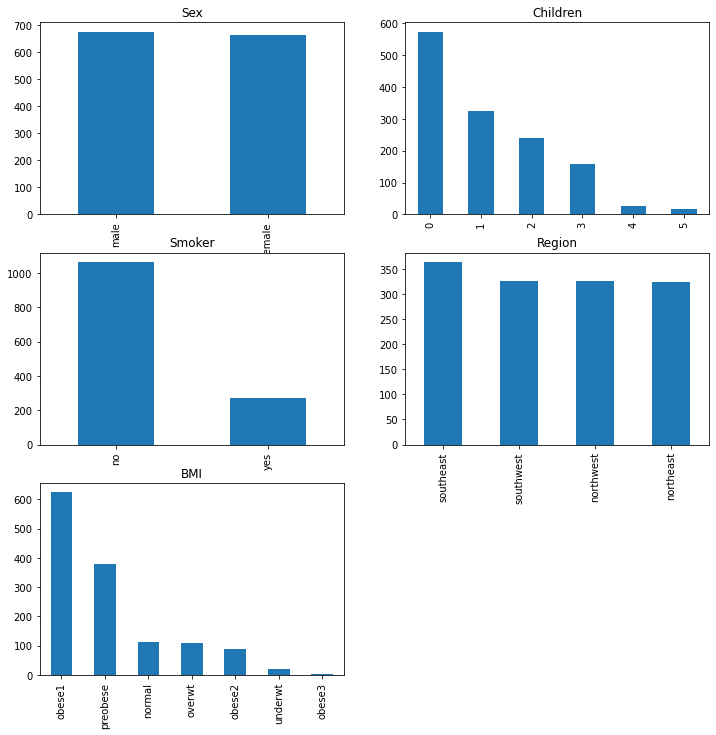

In [24]:
plt.subplot(3,2,1)
df['sex'].value_counts().plot(kind='bar',figsize=(12,12),title='Sex')
plt.subplot(3,2,2)
df['children'].value_counts().plot(kind='bar',figsize=(12,12),title='Children')
plt.subplot(3,2,3)
df['smoker'].value_counts().plot(kind='bar',figsize=(12,12),title='Smoker')
plt.subplot(3,2,4)
df['region'].value_counts().plot(kind='bar',figsize=(12,12),title='Region')
plt.subplot(3,2,5)
df1['bmi_bins'].value_counts().plot(kind='bar',figsize=(12,12),title='BMI')

## Encoding the categorical features

### Encoding in dataframe 1

In [25]:
le = LabelEncoder()

In [26]:
df['sex'] = le.fit_transform(df['sex'])
df['smoker'] = le.fit_transform(df['smoker'])

In [27]:
df.head()

,age,sex,bmi,charges in INR,children,smoker,region
0,19,0,27.900,16884.92400,0,1,southwest
1,18,1,33.770,1725.55230,1,0,southeast
2,28,1,33.000,4449.46200,3,0,southeast
3,33,1,22.705,21984.47061,0,0,northwest
4,32,1,28.880,3866.85520,0,0,northwest


In [28]:
df = pd.get_dummies(df,columns=['region'],drop_first=True)

In [29]:
df.head()

,age,sex,bmi,charges in INR,children,smoker,region_northwest,region_southeast,region_southwest
0,19,0,27.900,16884.92400,0,1,0,0,1
1,18,1,33.770,1725.55230,1,0,0,1,0
2,28,1,33.000,4449.46200,3,0,0,1,0
3,33,1,22.705,21984.47061,0,0,1,0,0
4,32,1,28.880,3866.85520,0,0,1,0,0


In [30]:
df = df[['age', 'sex', 'bmi', 'children', 'smoker',
       'region_northwest', 'region_southeast', 'region_southwest', 'charges in INR']]

In [31]:
df.head()

,age,sex,bmi,children,smoker,region_northwest,region_southeast,region_southwest,charges in INR
0,19,0,27.900,0,1,0,0,1,16884.92400
1,18,1,33.770,1,0,0,1,0,1725.55230
2,28,1,33.000,3,0,0,1,0,4449.46200
3,33,1,22.705,0,0,1,0,0,21984.47061
4,32,1,28.880,0,0,1,0,0,3866.85520


### Encoding bmi feature in dataframe 2

In [32]:
df1['bmi_bins'] = df1['bmi_bins'].replace({'underwt':1,'normal':2,'overwt':3,'preobese':4,'obese1':5,
                                         'obese2':6,'obese3':7})

In [33]:
df1.head()

,age,sex,bmi,charges in INR,children,smoker,region,bmi_bins
0,19,female,27.900,16884.92400,0,yes,southwest,4
1,18,male,33.770,1725.55230,1,no,southeast,5
2,28,male,33.000,4449.46200,3,no,southeast,5
3,33,male,22.705,21984.47061,0,no,northwest,2
4,32,male,28.880,3866.85520,0,no,northwest,4


In [34]:
df1.drop('bmi',axis=1,inplace=True)

In [35]:
df1.head()

,age,sex,charges in INR,children,smoker,region,bmi_bins
0,19,female,16884.92400,0,yes,southwest,4
1,18,male,1725.55230,1,no,southeast,5
2,28,male,4449.46200,3,no,southeast,5
3,33,male,21984.47061,0,no,northwest,2
4,32,male,3866.85520,0,no,northwest,4


In [36]:
df1['sex'] = le.fit_transform(df1['sex'])
df1['smoker'] = le.fit_transform(df1['smoker'])
df1 = pd.get_dummies(df1,columns=['region'],drop_first=True)

In [37]:
df1.head()

,age,sex,charges in INR,children,smoker,bmi_bins,region_northwest,region_southeast,region_southwest
0,19,0,16884.92400,0,1,4,0,0,1
1,18,1,1725.55230,1,0,5,0,1,0
2,28,1,4449.46200,3,0,5,0,1,0
3,33,1,21984.47061,0,0,2,1,0,0
4,32,1,3866.85520,0,0,4,1,0,0


In [38]:
df1 = df1[['age', 'sex', 'bmi_bins', 'children', 'smoker',
       'region_northwest', 'region_southeast', 'region_southwest', 'charges in INR']]

## Outlier treatment need not be done as the results do not lead to significant accuracy that is greater than the initial dataframes

## Multivariate analysis using regression

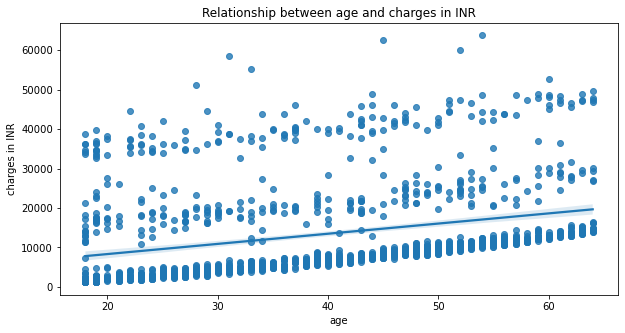

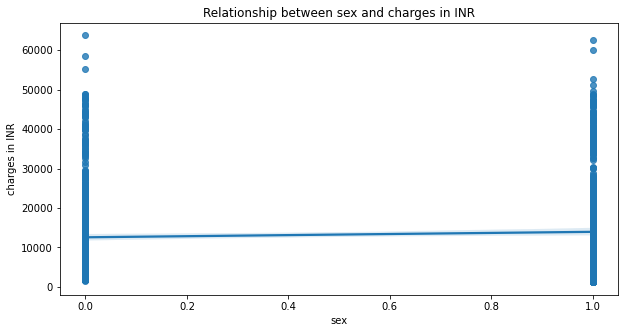

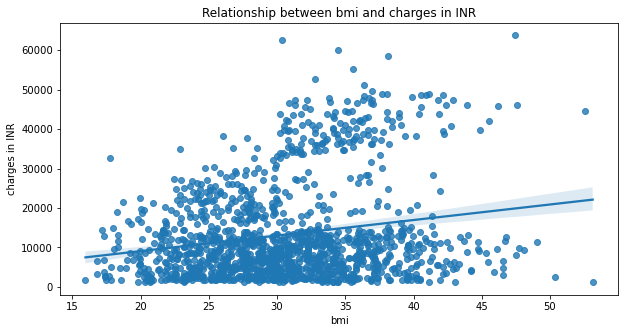

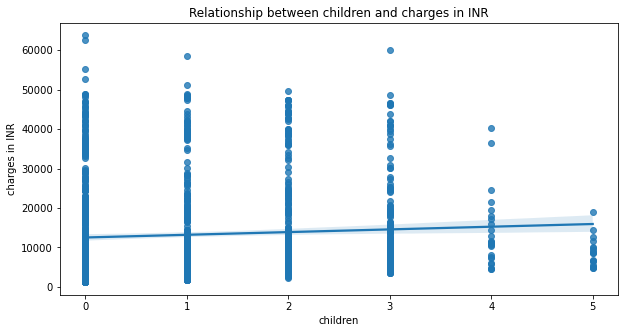

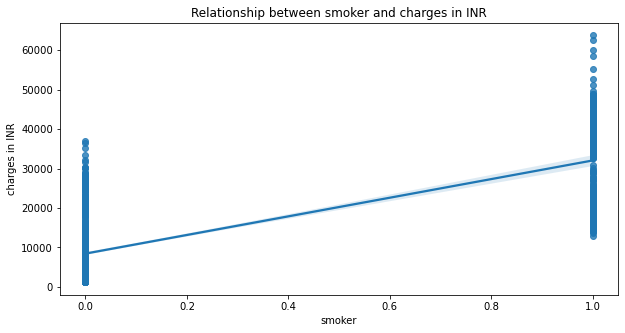

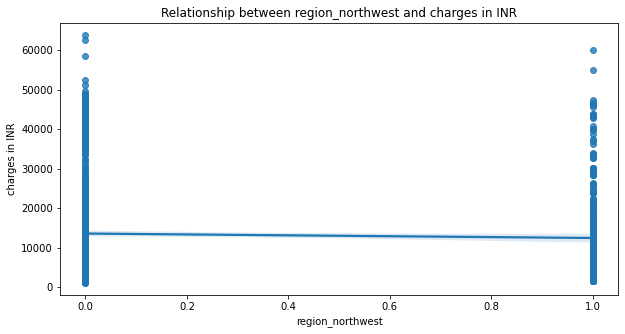

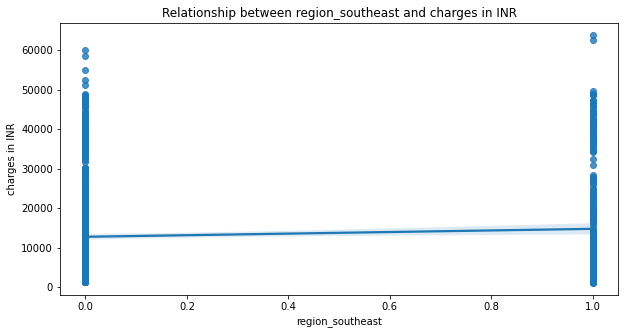

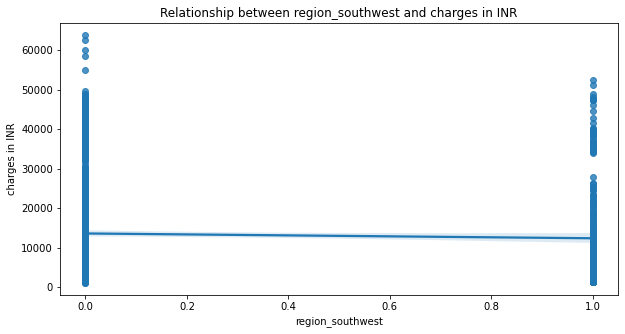

In [39]:
for col in df.columns:
    if col!= 'charges in INR':
        fig,ax1 = plt.subplots(figsize = (10,5))
        sns.regplot(x=df[col],y=df['charges in INR'],ax=ax1).set_title(f'Relationship between {col} and charges in INR')

### Analysis:
    1. Charges in INR and age are slightly positively correlated
    2. Charges in INR and sex are slightly positively correlated
    3. Charges in INR and bmi are slightly positively correlated
    4. Charges in INR and children are slightly positively correlated
    5. Charges in INR and smoker are highly positively correlated
    6. Charges in INR and region_northwest are slightly negatively correlated
    7. Charges in INR and region_southeast are slightly positively correlated
    8. Charges in INR and region_southwest are slightly negatively correlated

## Multicollinearity test

### Stage 1: Correlation heatmap

<AxesSubplot:>

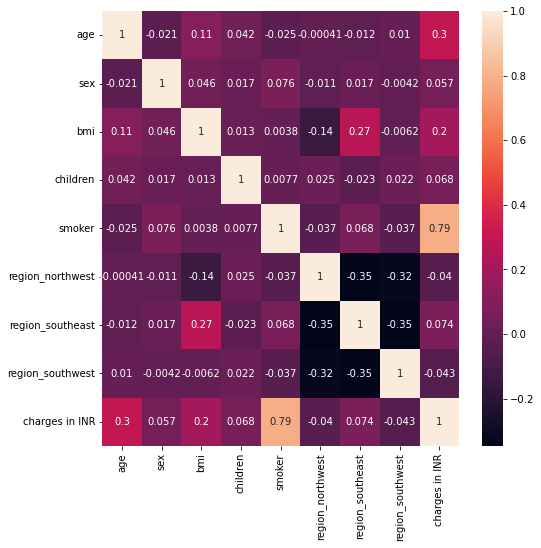

In [40]:
# Dataframe 1 (df)
corr = df.corr()
plt.subplots(figsize = (8,8))
sns.heatmap(corr,annot=True)

### Analysis:
    1. region_southeast is correlated to region_nortwest by 35%
    2. region_southwest is correlated to region_northwest by 32%
    3. region_southwest is correlated to region_southeast by 35%
- Conclusion: Some features do have correlation greater than 30% so multicollinearity exists as per stage 1 results

### Stage 2: Variance Inflation Factor(VIF)
    - Formula for VIF is : 1/(1-r2)
    - Steps:
        1. Regress every independent variable with each other and find the R square
        2. Find out the VIF using the above formula
        3. If VIF is more than 5 then we can say multicollinearity exists(threshold can be 5 or 10)

In [41]:
def VIF(features):
    vif = pd.DataFrame()
    vif['VIF Score'] = [variance_inflation_factor(features.values,i) for i in range(features.shape[1])]
    vif['Features']  = features.columns
    vif.sort_values(by=['VIF Score'],ascending= False,inplace=True)
    return vif

In [42]:
# Dataframe 1 (df without outlier treatment)
VIF(df.drop('charges in INR',axis=1))

,VIF Score,Features
2,11.358443,bmi
0,7.686965,age
6,2.265564,region_southeast
1,2.003185,sex
7,1.960745,region_southwest
5,1.890281,region_northwest
3,1.809930,children
4,1.261233,smoker


In [43]:
# Dataframe 2 (binned bmi without outlier treatment)
VIF(df1.drop('charges in INR',axis=1))

,VIF Score,Features
2,9.447590,bmi_bins
0,6.965441,age
6,2.187402,region_southeast
1,1.983505,sex
7,1.921909,region_southwest
5,1.868676,region_northwest
3,1.797333,children
4,1.256506,smoker


### Analysis: (for dataframe 1 & 2)
    - Only bmi_bins and age have a VIF greater than 5 so we can conclude multicollinearity exists as per stage 2 results

### Correlation with target variable

In [44]:
def cwt(data,t_col):
    independent_variables = data.drop(t_col,axis = 1).columns
    corr_result =[]
    for col in independent_variables:
        corr_result.append(data[t_col].corr(data[col]))
    result = pd.DataFrame([independent_variables,corr_result],index=['Independent_variables','Correlation']).T
    return result.sort_values(by= ['Correlation'],ignore_index=True)

In [45]:
# Dataframe 2 (binned bmi without outlier treatment) 
# Dataframe 1 has the same correlation
cwt(df1,'charges in INR')

,Independent_variables,Correlation
0,region_southwest,-0.04321
1,region_northwest,-0.039905
2,sex,0.057292
3,children,0.067998
4,region_southeast,0.073982
5,bmi_bins,0.18282
6,age,0.299008
7,smoker,0.787251


### Analsis:
    1. smoker has a high correlation of 79% with charges in INR
    2. age has a 30% correlation with charges in INR

## Applying PCA to treat multicollinearity

In [46]:
def pca_func(X):
    n_comp = len(X.columns)
    pcs =1
    # Feature scaling
    X = StandardScaler().fit_transform(X)
    
    # Applying PCA
    for i in range(1,n_comp):
        pca = PCA(n_components=i)
        p_comp = pca.fit_transform(X)
        evr = np.cumsum(pca.explained_variance_ratio_)
        if(evr[i-1]>0.9):
            pcs = i
            break
            
    print('Explained variance ratio after PCA is:',evr)
#creating dataframe using principal components
    col = []
    for j in range(1,pcs+1):
        col.append('PC_'+str(j))
    pca_df = pd.DataFrame(data=p_comp,columns=col)   
    return pca_df

In [47]:
# Dataframe 3 (pca on df)
pca_df = pca_func(df.drop('charges in INR',axis=1))

Explained variance ratio after PCA is: [0.19216849 0.35803641 0.49504904 0.62782657 0.74718808 0.86298045
 0.96076588]


In [48]:
pca_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7
0,-0.553534,1.555510,2.094445,-0.668775,0.409312,1.685415,1.064267
1,1.655404,-0.525503,1.093006,-0.384095,0.313574,-1.602367,0.000092
2,1.581891,-0.431678,0.203768,0.748523,1.314180,-1.597481,-0.434006
3,-1.775405,-1.417192,0.742248,-0.125408,-1.049333,-0.730506,-0.454299
4,-1.285313,-1.360950,0.477302,-0.012752,-1.213210,-0.894684,0.341390


In [49]:
# Dataframe 4 (pca on df1)
pca_df1= pca_func(df1.drop('charges in INR',axis=1))

Explained variance ratio after PCA is: [0.1847169  0.35041978 0.4887735  0.62180977 0.74239668 0.85841649
 0.96065564]


In [50]:
pca_df1.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7
0,-0.505054,1.558413,2.085037,-0.375903,0.233724,1.472883,-1.480313
1,1.759591,-0.423877,0.985975,-0.197863,-0.062622,-1.689932,-0.156208
2,1.719366,-0.332171,0.025071,0.774047,1.070500,-1.787350,0.143695
3,-1.993276,-1.544459,1.107908,-0.118601,-0.878494,-0.426624,1.266510
4,-1.224315,-1.425253,0.402006,0.102138,-1.369038,-0.723043,-0.065548


In [51]:
# Dataframe 5 (pca on df for relevant variables)
pca1_df = pca_func(df[['age','bmi']])

Explained variance ratio after PCA is: [0.55463594]


In [52]:
pca1_df.head()

,PC_1
0,-1.337906
1,-0.707350
2,-0.293199
3,-1.235654
4,-0.569720


In [53]:
# Dataframe 6 (pca on df1 for relevant variables)
pca1_df1 = pca_func(df1[['age','bmi_bins']])

Explained variance ratio after PCA is: [0.55476874]


In [54]:
pca1_df1.head()

,PC_1
0,1.216082
1,0.624183
2,0.120715
3,1.795716
4,0.561573


### Joining PCA feature with target feature

In [55]:
# Dataframe 7 (joining pca_df with target variable)
transformed_df = pca_df.join(df['charges in INR'])

In [56]:
transformed_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,charges in INR
0,-0.553534,1.555510,2.094445,-0.668775,0.409312,1.685415,1.064267,16884.92400
1,1.655404,-0.525503,1.093006,-0.384095,0.313574,-1.602367,0.000092,1725.55230
2,1.581891,-0.431678,0.203768,0.748523,1.314180,-1.597481,-0.434006,4449.46200
3,-1.775405,-1.417192,0.742248,-0.125408,-1.049333,-0.730506,-0.454299,21984.47061
4,-1.285313,-1.360950,0.477302,-0.012752,-1.213210,-0.894684,0.341390,3866.85520


In [57]:
# Dataframe 8 (joining pca_df1 with target variable)
transformed_df1 = pca_df1.join(df1['charges in INR'])

In [58]:
# Dataframe 9 (joining pca1_df with rest of features)
transformed1_df = pca1_df.join(df[['sex','children','smoker','region_northwest','region_southeast',
                                   'region_southwest','charges in INR']])

In [59]:
transformed1_df.head()

,PC_1,sex,children,smoker,region_northwest,region_southeast,region_southwest,charges in INR
0,-1.337906,0,0,1,0,0,1,16884.92400
1,-0.707350,1,1,0,0,1,0,1725.55230
2,-0.293199,1,3,0,0,1,0,4449.46200
3,-1.235654,1,0,0,1,0,0,21984.47061
4,-0.569720,1,0,0,1,0,0,3866.85520


In [60]:
# Dataframe 10 (joining pca1_df1 with rest of features)
transformed1_df1 = pca1_df1.join(df1[['sex','children','smoker','region_northwest','region_southeast', 
                                      'region_southwest','charges in INR']])

## Model building
    - Train test split
    - Cross validation
    - Hyperparameter tuning

### Test train split

In [61]:
def train_and_test_split(data,y,test_size=0.3,random_state=10):
    X = data.drop(y,1)
    return train_test_split(X,data[y],test_size=test_size,random_state=random_state)

In [62]:
def model_builder(model_name,estimator,data,t_col):
    X_train,X_test,y_train,y_test = train_and_test_split(data,t_col)
    estimator.fit(X_train,y_train)
    y_pred = estimator.predict(X_test)
    r2score = r2_score(y_test,y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    return model_name,r2score,rmse

### Building multiple models

In [63]:
def multiple_models(data,data1,t_col):
    col = ['Model_Name','R2 Score','RMSE']
    result = pd.DataFrame(columns=col)
    
    # Adding values to result dataframe
    result.loc[len(result)] = model_builder('Linear regression',LinearRegression(),data1,t_col)
    result.loc[len(result)] = model_builder('Lasso regression',Lasso(),data1,t_col)
    result.loc[len(result)] = model_builder('Ridge regression',Ridge(),data1,t_col)
    result.loc[len(result)] = model_builder('Decision Tree regressor',DecisionTreeRegressor(),data,t_col)
    result.loc[len(result)] = model_builder('Support Vector regressor',SVR(),data1,t_col)
    result.loc[len(result)] = model_builder('K Neighbors regressor',KNeighborsRegressor(),data1,t_col)
    result.loc[len(result)] = model_builder('Random Forest regressor',RandomForestRegressor(),data,t_col)
    result.loc[len(result)] = model_builder('Adaboost regressor',AdaBoostRegressor(),data,t_col)
    result.loc[len(result)] = model_builder('Gradient Boost regressor',GradientBoostingRegressor(),data,t_col)
    result.loc[len(result)] = model_builder('XGBoost regressor',XGBRegressor(),data,t_col)
    
    return result.sort_values(by=['R2 Score'],ascending=False,ignore_index=True)

In [64]:
# 1. pca_df
multiple_models(df,transformed_df,'charges in INR')

,Model_Name,R2 Score,RMSE
0,Gradient Boost regressor,0.851766,4387.407844
1,Adaboost regressor,0.831309,4680.362765
2,Random Forest regressor,0.818349,4856.837198
3,XGBoost regressor,0.770780,5455.824258
4,K Neighbors regressor,0.764355,5531.762981
5,Ridge regression,0.713854,6095.757520
6,Lasso regression,0.713727,6097.112434
7,Linear regression,0.713712,6097.278745
8,Decision Tree regressor,0.683174,6414.228287
9,Support Vector regressor,-0.088379,11888.422090


### Analysis:
    The top 5 models in the dataset are:
        1. Gradient Boost
        2. Random Forest
        3. Adaboost
        4. XG Boost
        5. K Neighbors

In [65]:
# 2. pca_df1
multiple_models(df1,transformed_df1,'charges in INR')

,Model_Name,R2 Score,RMSE
0,Gradient Boost regressor,0.848919,4429.335406
1,Adaboost regressor,0.819849,4836.733053
2,Random Forest regressor,0.800696,5087.351530
3,K Neighbors regressor,0.764257,5532.904984
4,XGBoost regressor,0.750680,5690.008317
5,Ridge regression,0.715010,6083.435052
6,Lasso regression,0.714903,6084.580872
7,Linear regression,0.714881,6084.810791
8,Decision Tree regressor,0.641034,6827.490554
9,Support Vector regressor,-0.088337,11888.194054


### Analysis:
    The top 5 models in the dataset are:
        1. Gradient Boost
        2. Adaboost
        3. Random Forest
        4. K Neighbors
        5. XG Boost

In [66]:
# 3. pca1_df
multiple_models(df,transformed1_df,'charges in INR')

,Model_Name,R2 Score,RMSE
0,Gradient Boost regressor,0.850154,4411.204655
1,Random Forest regressor,0.823760,4783.946220
2,Adaboost regressor,0.811650,4945.576813
3,XGBoost regressor,0.770780,5455.824258
4,Ridge regression,0.711372,6122.139221
5,Lasso regression,0.710756,6128.672903
6,Linear regression,0.710708,6129.179249
7,Decision Tree regressor,0.694262,6300.989144
8,K Neighbors regressor,0.642123,6817.122298
9,Support Vector regressor,-0.091746,11906.796130


### Analysis:
    The top 5 models in the dataset are:
        1. Gradient Boost
        2. Random Forest
        3. Adaboost
        4. XG Boost
        5. Ridge regression

In [67]:
# 4. pca1_df1
multiple_models(df1,transformed1_df1,'charges in INR')

,Model_Name,R2 Score,RMSE
0,Gradient Boost regressor,0.848919,4429.335406
1,Adaboost regressor,0.811364,4949.325357
2,Random Forest regressor,0.807270,5002.746746
3,XGBoost regressor,0.750680,5690.008317
4,Ridge regression,0.712794,6107.044774
5,Lasso regression,0.712285,6112.448652
6,Linear regression,0.712242,6112.910766
7,Decision Tree regressor,0.656683,6677.007249
8,K Neighbors regressor,0.635520,6879.721695
9,Support Vector regressor,-0.090983,11902.633661


### Analysis:
    The top 5 models in the dataset are:
        1. Gradient Boost
        2. Random Forest
        3. Adaboost
        4. XG Boost
        5. Ridge regression

In [68]:
# 5. df without pca
multiple_models(df,df,'charges in INR')

,Model_Name,R2 Score,RMSE
0,Gradient Boost regressor,0.851818,4386.635006
1,Adaboost regressor,0.829742,4702.062590
2,Random Forest regressor,0.825595,4758.978408
3,XGBoost regressor,0.770780,5455.824258
4,Ridge regression,0.717212,6059.886763
5,Lasso regression,0.716653,6065.875800
6,Linear regression,0.716612,6066.309248
7,Decision Tree regressor,0.679998,6446.297749
8,K Neighbors regressor,0.109038,10756.318655
9,Support Vector regressor,-0.091910,11907.690621


### Analysis:
    The top 5 models in the dataset are:
        1. Gradient Boost
        2. Random Forest
        3. Adaboost
        4. XG Boost
        5. Ridge regression

In [69]:
# 6. df1 without pca
multiple_models(df1,df1,'charges in INR')

,Model_Name,R2 Score,RMSE
0,Gradient Boost regressor,0.848917,4429.364738
1,Adaboost regressor,0.809441,4974.498454
2,Random Forest regressor,0.807879,4994.845610
3,XGBoost regressor,0.750680,5690.008317
4,Ridge regression,0.717909,6052.411880
5,Lasso regression,0.717425,6057.602726
6,Linear regression,0.717391,6057.965366
7,Decision Tree regressor,0.652483,6717.721012
8,K Neighbors regressor,0.293860,9575.898766
9,Support Vector regressor,-0.091905,11907.661703


### Analysis:
    The top 5 models in the dataset are:
        1. Gradient Boost
        2. Random Forest
        3. Adaboost
        4. XG Boost
        5. Ridge regression

## Cross validation

In [70]:
def kfold_cv(data,data1,t_col,cv=10):
    model_names = [LinearRegression(),Lasso(),Ridge(),SVR(),KNeighborsRegressor(),DecisionTreeRegressor(),
                   RandomForestRegressor(),AdaBoostRegressor(),GradientBoostingRegressor(),XGBRegressor()]
    scores = ['Score_LR','Score_LS','Score_RD','Score_SVR','Score_KNR','Score_DTR','Score_RFR',
             'Score_ABR','Score_GBR','Score_XGBR']
    
    for model,i in zip(model_names,range(len(scores))):
        if(i<=4):
            scores[i] = (cross_val_score(estimator=model,X=data1.drop(t_col,1),y=data1[t_col],cv=cv))
        else:
            scores[i] = (cross_val_score(estimator=model,X=data.drop(t_col,1),y=data[t_col],cv=cv))
    
    result = []
    for i in range(len(model_names)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        model_name = type(model_names[i]).__name__
        temp = [model_name,score_mean,score_std]
        result.append(temp)
    
    result_df = pd.DataFrame(result,columns=['Model Name','R2 Score','Score Std Deviation'])
    return result_df.sort_values(by=['R2 Score'],ascending=False,ignore_index=True)

In [71]:
# 1. pca_df
kfold_cv(df,transformed_df,'charges in INR')

,Model Name,R2 Score,Score Std Deviation
0,GradientBoostingRegressor,0.856104,0.045489
1,RandomForestRegressor,0.834859,0.043449
2,AdaBoostRegressor,0.823531,0.031897
3,XGBRegressor,0.806691,0.056461
4,KNeighborsRegressor,0.789977,0.035237
5,Ridge,0.743421,0.042502
6,Lasso,0.743413,0.042574
7,LinearRegression,0.743412,0.042584
8,DecisionTreeRegressor,0.678851,0.074459
9,SVR,-0.101278,0.030322


### Analysis:
    The top 5 models in the dataset are:
        1. Gradient Boost
        2. Random Forest
        3. Adaboost
        4. XG Boost
        5. K Neighbors

In [72]:
# 2. pca_df1
kfold_cv(df1,transformed_df1,'charges in INR')

,Model Name,R2 Score,Score Std Deviation
0,GradientBoostingRegressor,0.854638,0.045857
1,RandomForestRegressor,0.823399,0.040443
2,XGBRegressor,0.789695,0.043974
3,KNeighborsRegressor,0.783838,0.039392
4,Ridge,0.742050,0.038399
5,Lasso,0.742042,0.038463
6,LinearRegression,0.742042,0.038473
7,AdaBoostRegressor,0.730139,0.079185
8,DecisionTreeRegressor,0.705209,0.047554
9,SVR,-0.101282,0.030362


### Analysis:
    The top 5 models in the dataset are:
        1. Gradient Boost
        2. Random Forest
        3. XG Boost
        4. K Neighbors
        5. Ridge regression

In [73]:
# 3. pca1_df
kfold_cv(df,transformed1_df,'charges in INR')

,Model Name,R2 Score,Score Std Deviation
0,GradientBoostingRegressor,0.856009,0.045260
1,RandomForestRegressor,0.834113,0.041339
2,AdaBoostRegressor,0.816444,0.043202
3,XGBRegressor,0.806691,0.056461
4,Ridge,0.737946,0.040874
5,Lasso,0.737928,0.041251
6,LinearRegression,0.737926,0.041294
7,KNeighborsRegressor,0.691258,0.039409
8,DecisionTreeRegressor,0.679739,0.073695
9,SVR,-0.102740,0.029950


### Analysis:
    The top 5 models in the dataset are:
        1. Gradient Boost
        2. Random Forest
        3. Adaboost
        4. XG Boost
        5. Ridge regression

In [74]:
# 4. pca1_df1
kfold_cv(df1,transformed1_df1,'charges in INR')

,Model Name,R2 Score,Score Std Deviation
0,GradientBoostingRegressor,0.854627,0.045871
1,RandomForestRegressor,0.822358,0.045577
2,XGBRegressor,0.789695,0.043974
3,Ridge,0.735103,0.034920
4,Lasso,0.735083,0.035275
5,LinearRegression,0.735081,0.035310
6,AdaBoostRegressor,0.725215,0.073910
7,DecisionTreeRegressor,0.693794,0.064519
8,KNeighborsRegressor,0.683113,0.048936
9,SVR,-0.102866,0.029801


### Analysis:
    The top 5 models in the dataset are:
        1. Gradient Boost
        2. Random Forest
        3. XG Boost
        4. Ridge
        5. Lasso

In [75]:
# 5. df without pca
kfold_cv(df,df,'charges in INR')

,Model Name,R2 Score,Score Std Deviation
0,GradientBoostingRegressor,0.856129,0.045291
1,RandomForestRegressor,0.832722,0.041339
2,AdaBoostRegressor,0.812070,0.032224
3,XGBRegressor,0.806691,0.056461
4,Ridge,0.744521,0.042546
5,Lasso,0.744506,0.042914
6,LinearRegression,0.744501,0.042945
7,DecisionTreeRegressor,0.693324,0.061686
8,KNeighborsRegressor,0.150008,0.081812
9,SVR,-0.104994,0.030682


### Analysis:
    The top 5 models in the dataset are:
        1. Gradient Boost
        2. Random Forest
        3. Adaboost
        4. XG Boost
        5. Ridge regression

In [76]:
# 6. df1 without pca
kfold_cv(df1,df1,'charges in INR')

,Model Name,R2 Score,Score Std Deviation
0,GradientBoostingRegressor,0.854616,0.045928
1,RandomForestRegressor,0.823319,0.044034
2,XGBRegressor,0.789695,0.043974
3,Ridge,0.743012,0.038181
4,Lasso,0.742996,0.038533
5,LinearRegression,0.742990,0.038555
6,AdaBoostRegressor,0.720249,0.072705
7,DecisionTreeRegressor,0.697101,0.047724
8,KNeighborsRegressor,0.376026,0.052215
9,SVR,-0.104862,0.030909


### Analysis:
    The top 5 models in the dataset are:
        1. Gradient Boost
        2. Random Forest
        3. XG Boost
        4. AdaBoost
        5. Ridge regression

## Hyperparameter tuning

In [77]:
def tuning(X,y,X1,y1,cv=10):
    # Creating the parameter grid
    param_las = {'alpha':[1e-15,1e-13,1e-11,1e-9,1e-7,1e-5,1e-5,1e-3,1e-1,0,1,2,3,4,5,6,7,8,9,10,20,30,40,50,
                          60,70,80,90,100,200,300,400,500]}
    param_rds = {'alpha':[1e-15,1e-13,1e-11,1e-9,1e-7,1e-5,1e-5,1e-3,1e-1,0,1,2,3,4,5,6,7,8,9,10,20,30,40,50,
                          60,70,80,90,100,200,300,400,500]} 
    param_knn = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]}
    param_dtr = {'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
                'max_features':['auto', 'sqrt', 'log2']}
    param_adb = {'learning_rate':[0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
    param_gboost = {'alpha':[0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
    param_xgb = {'alpha':[0.1,0.3,0.5,0.7,0.9,1],'gamma':[0,10,20,30,40,50,60,70,80,90,100],
                'eta':[0.01,0.1,0.2]}
    param_rf = {'n_estimators':[50,100,150,200,250,300],
               'criterion':['squared_error', 'absolute_error', 'poisson']}
    
    # Hyperparameter tuning
    tune_las = RandomizedSearchCV(Lasso(),param_las,cv=cv,random_state=10)
    tune_rds = RandomizedSearchCV(Ridge(),param_rds,cv=cv,random_state=10)
    tune_knn = RandomizedSearchCV(KNeighborsRegressor(),param_knn,cv=cv,random_state=10)  
    tune_dtr = RandomizedSearchCV(DecisionTreeRegressor(),param_dtr,cv=cv,random_state=10)    
    tune_adb = RandomizedSearchCV(AdaBoostRegressor(),param_adb,cv=cv,random_state=10)    
    tune_gboost = RandomizedSearchCV(GradientBoostingRegressor(),param_gboost,cv=cv,random_state=10)    
    tune_xgb = RandomizedSearchCV(XGBRegressor(),param_xgb,cv=cv,random_state=10)    
    tune_rf = RandomizedSearchCV(RandomForestRegressor(),param_rf,cv=cv,random_state=10) 
    
    # Model fitting
    tune_models = [tune_las,tune_rds,tune_knn,tune_dtr,tune_adb,tune_gboost,tune_xgb,tune_rf]
    models = ['Lasso','Ridge','KNN','DTR','ADB','GBoost','XGB','RF']
    for i in range(len(tune_models)):
        if(i<=2):
            tune_models[i].fit(X1,y1)
        else:
            tune_models[i].fit(X,y)
        
    for i in range(len(tune_models)):
        print('Model: ',models[i])
        print('Best parameters: ',tune_models[i].best_params_)

In [78]:
tuning(df.drop('charges in INR',axis=1),df['charges in INR'],
       transformed_df.drop('charges in INR',axis=1),transformed_df['charges in INR'])

Model:  Lasso
Best parameters:  {'alpha': 4}
Model:  Ridge
Best parameters:  {'alpha': 4}
Model:  KNN
Best parameters:  {'n_neighbors': 7}
Model:  DTR
Best parameters:  {'max_features': 'auto', 'criterion': 'squared_error'}
Model:  ADB
Best parameters:  {'learning_rate': 0.001}
Model:  GBoost
Best parameters:  {'alpha': 0.01}
Model:  XGB
Best parameters:  {'gamma': 90, 'eta': 0.1, 'alpha': 0.1}
Model:  RF
Best parameters:  {'n_estimators': 200, 'criterion': 'squared_error'}


In [79]:
def CV_post_hpt(X,y,X1,y1,cv=10):
    score_lr = cross_val_score(LinearRegression(),X1,y1,cv=cv)
    score_las = cross_val_score(Lasso(alpha=4),X1,y1,cv=cv)
    score_rd = cross_val_score(Ridge(alpha=4),X1,y1,cv=cv)
    score_knn = cross_val_score(KNeighborsRegressor(n_neighbors=7),X1,y1,cv=cv)
    score_dtr = cross_val_score(DecisionTreeRegressor(criterion='friedman_mse',max_features='log2'),X,y,cv=cv)
    score_svr = cross_val_score(SVR(),X1,y1,cv=cv)
    score_rf = cross_val_score(RandomForestRegressor(n_estimators=300,criterion='squared_error'),X,y,cv=cv)
    score_adb = cross_val_score(AdaBoostRegressor(learning_rate=0.01),X,y,cv=cv)
    score_gboost = cross_val_score(GradientBoostingRegressor(alpha=0.5),X,y,cv=cv)
    score_xgb = cross_val_score(XGBRegressor(alpha=0.1,gamma=90,eta=0.1),X,y,cv=cv)
    
    model_names = ['Linear Regression','Lasso','Ridge','Decision Tree Regressor','SVR','KNeighbors Regressor',
                   'Random Forest Regressor','AdaBoost Regressor','Gradient Boosting Regressor','XGB Regressor']
    scores = [score_lr,score_las,score_rd,score_dtr,score_svr,score_knn,score_rf,score_adb,score_gboost,score_xgb]
    
    result = []
    for i in range(len(model_names)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        m_name = model_names[i]
        temp = [m_name,score_mean,score_std]
        result.append(temp)
    result_df = pd.DataFrame(result,columns=['model names','R2 Mean','R2 Std'])
    return result_df.sort_values(by='R2 Mean',ascending=False,ignore_index=True)

In [80]:
CV_post_hpt(df.drop('charges in INR',axis=1),df['charges in INR'],
       transformed_df.drop('charges in INR',axis=1),transformed_df['charges in INR'])

,model names,R2 Mean,R2 Std
0,Gradient Boosting Regressor,0.856065,0.045310
1,AdaBoost Regressor,0.846851,0.044925
2,Random Forest Regressor,0.835518,0.042143
3,XGB Regressor,0.835441,0.048385
4,KNeighbors Regressor,0.798661,0.036825
5,Ridge,0.743439,0.042255
6,Lasso,0.743416,0.042545
7,Linear Regression,0.743412,0.042584
8,Decision Tree Regressor,0.675990,0.105137
9,SVR,-0.101278,0.030322


## Clustering

<AxesSubplot:xlabel='age', ylabel='charges in INR'>

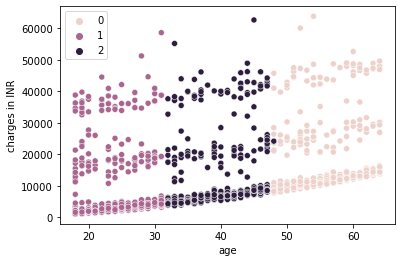

In [81]:
labels = KMeans(n_clusters = 3,random_state = 10)
cluster = labels.fit_predict(df.drop('charges in INR',axis=1))
sns.scatterplot(x = df['age'],y = df['charges in INR'],hue = cluster)

In [82]:
def clustering(x,t_col,cluster):
    column = list(set(list(x.columns)) - set(x[t_col]))
    r = int(len(column)/2)
    if(r%2==0):
        r=r
    else:
        r+=1
    f,ax = plt.subplots(r,2,figsize=(20,18))
    a=0
    for row in range(r):
        for col in range(2):
            if(a!=len(column)):
                ax[row][col].scatter(x[t_col],x[column[a]],c=cluster)
                ax[row][col].set_xlabel(t_col)               
                ax[row][col].set_ylabel(column[a])               
                a+=1

In [83]:
X = df.drop('charges in INR',axis=1)

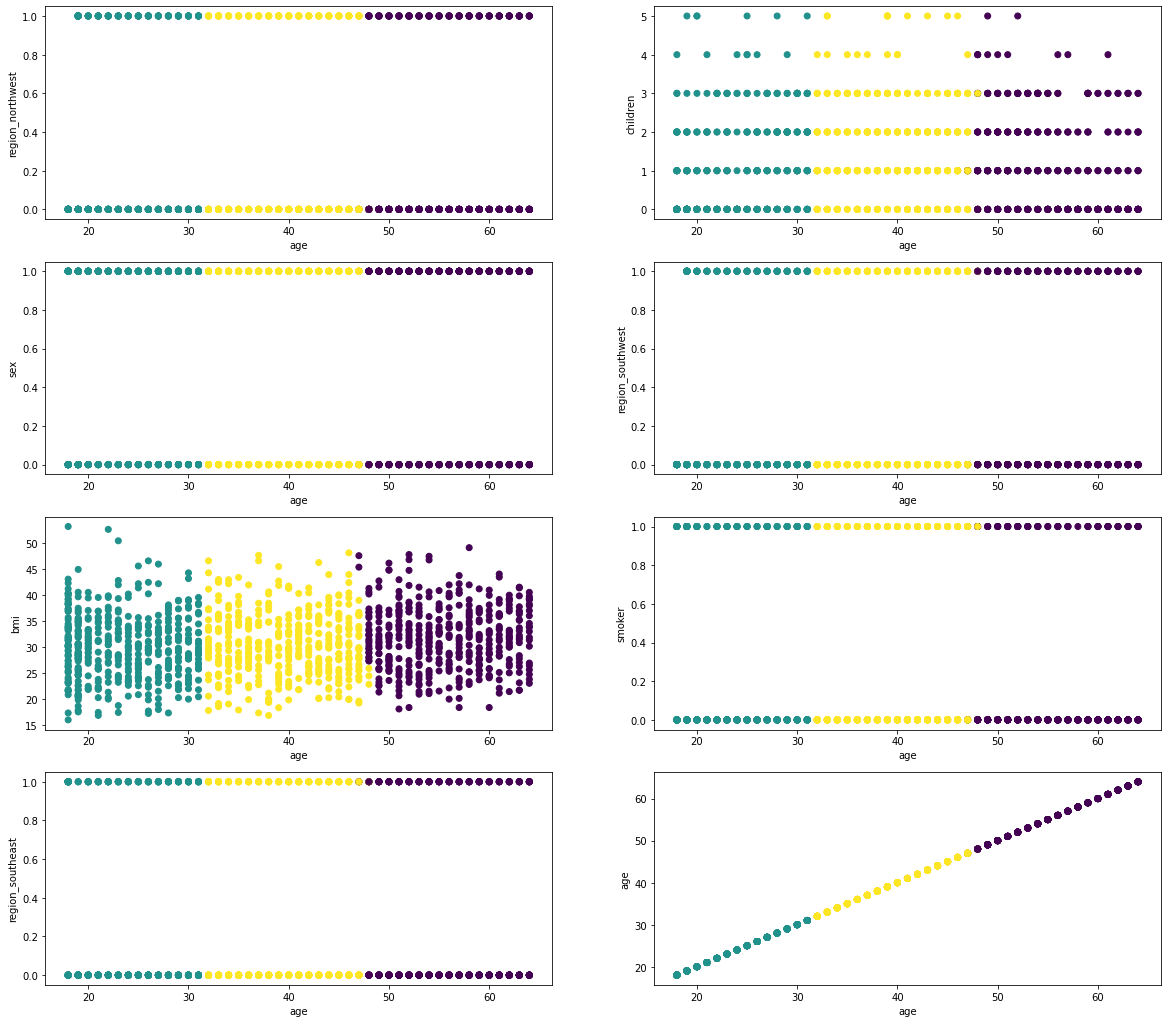

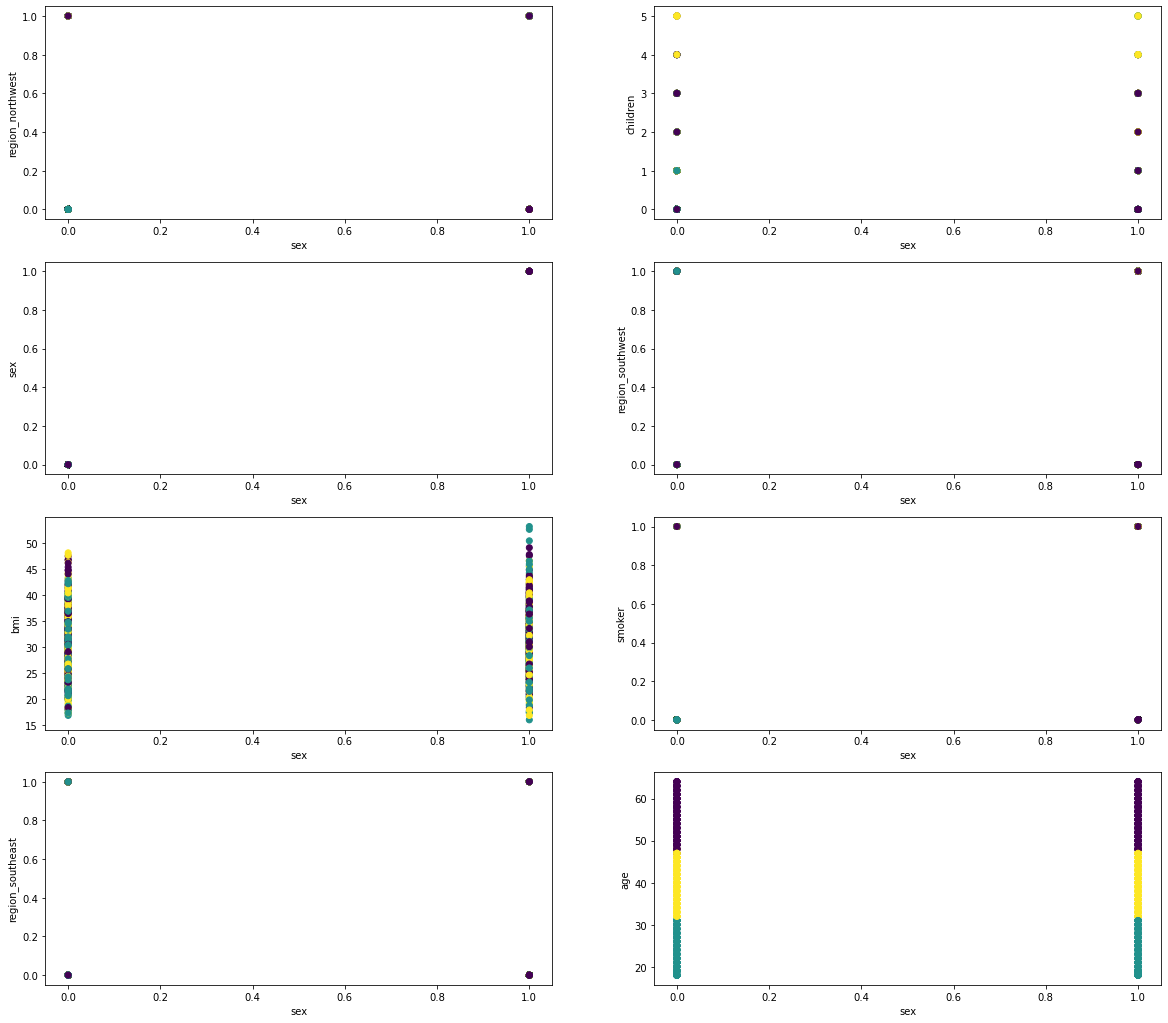

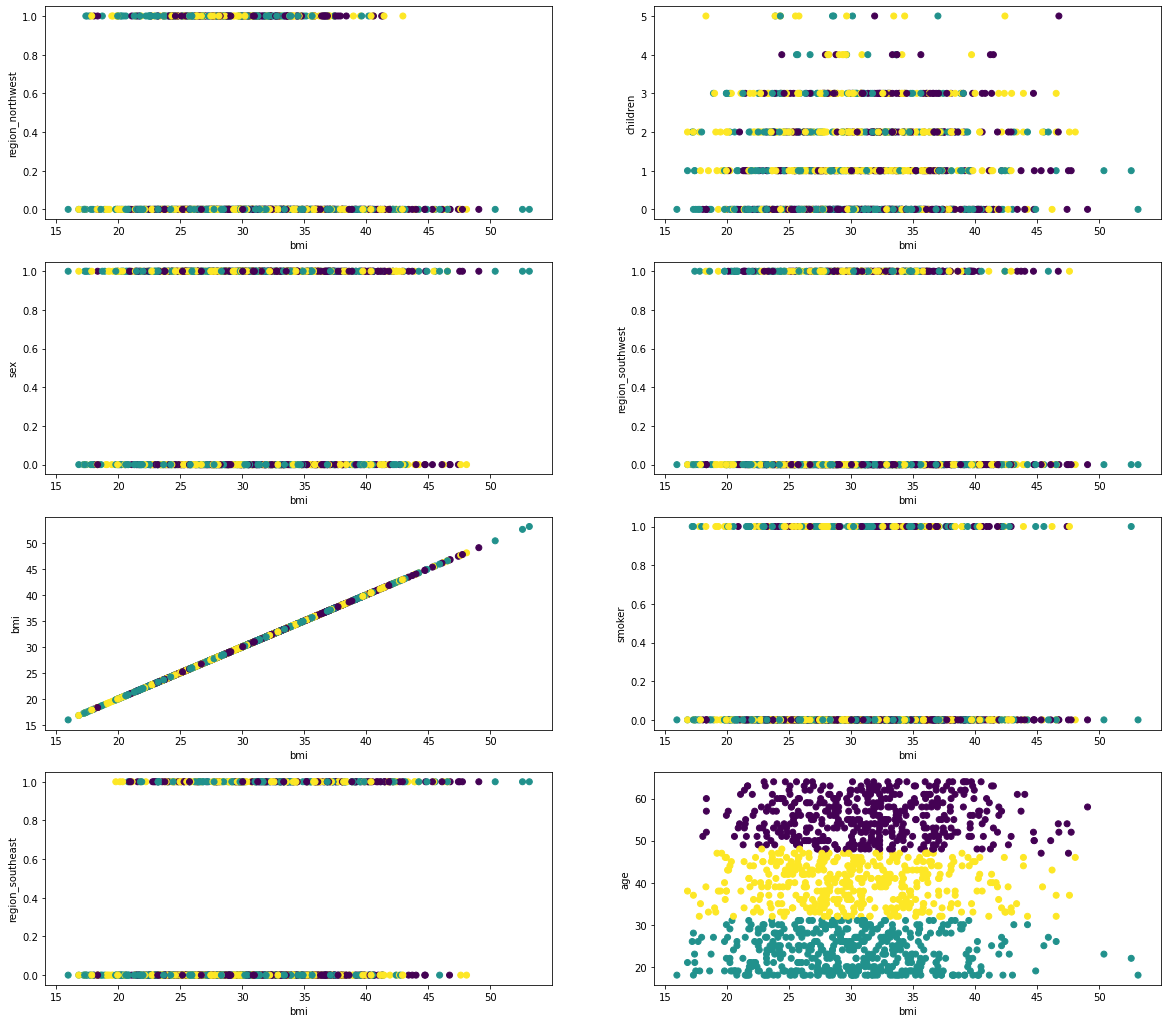

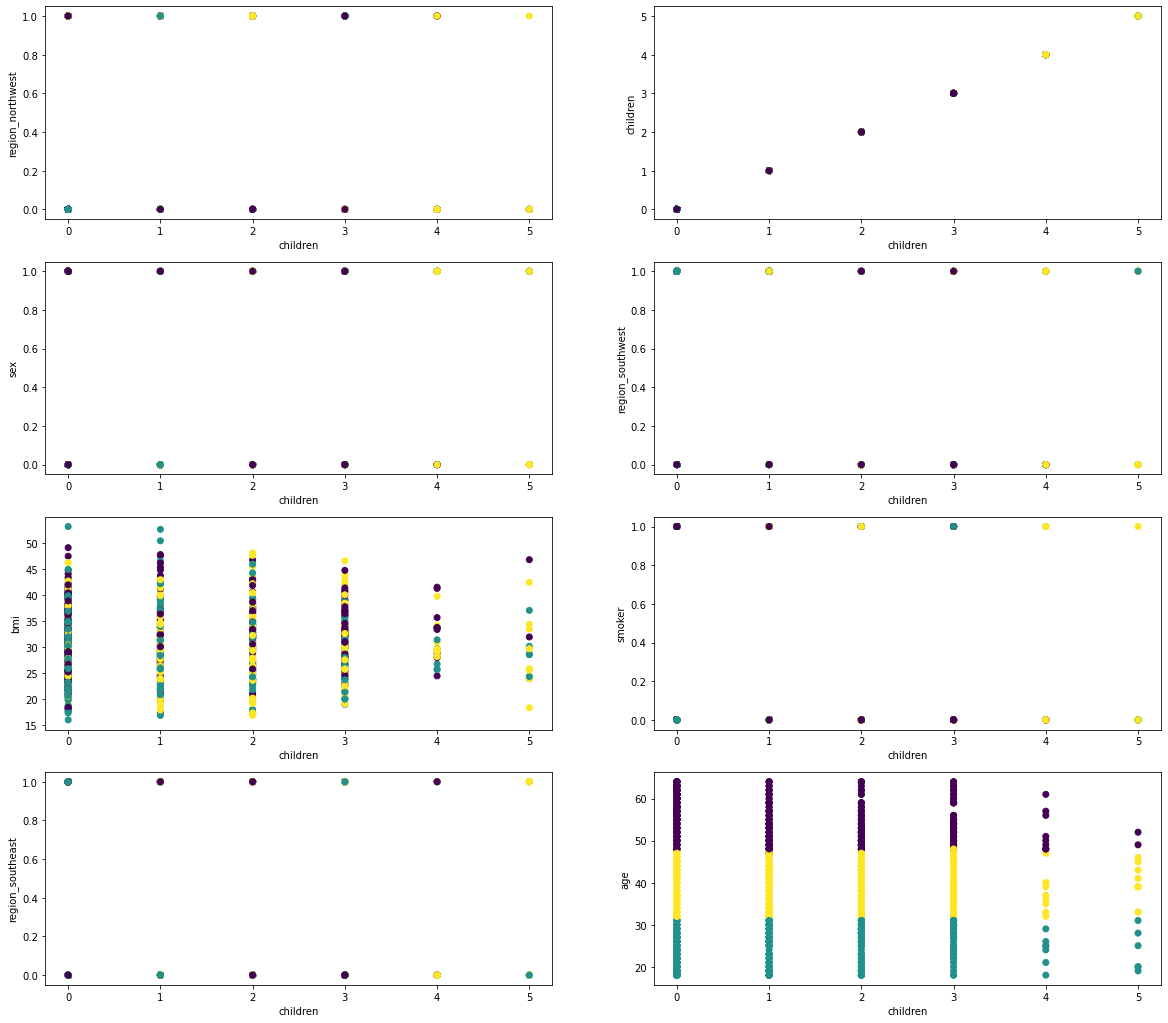

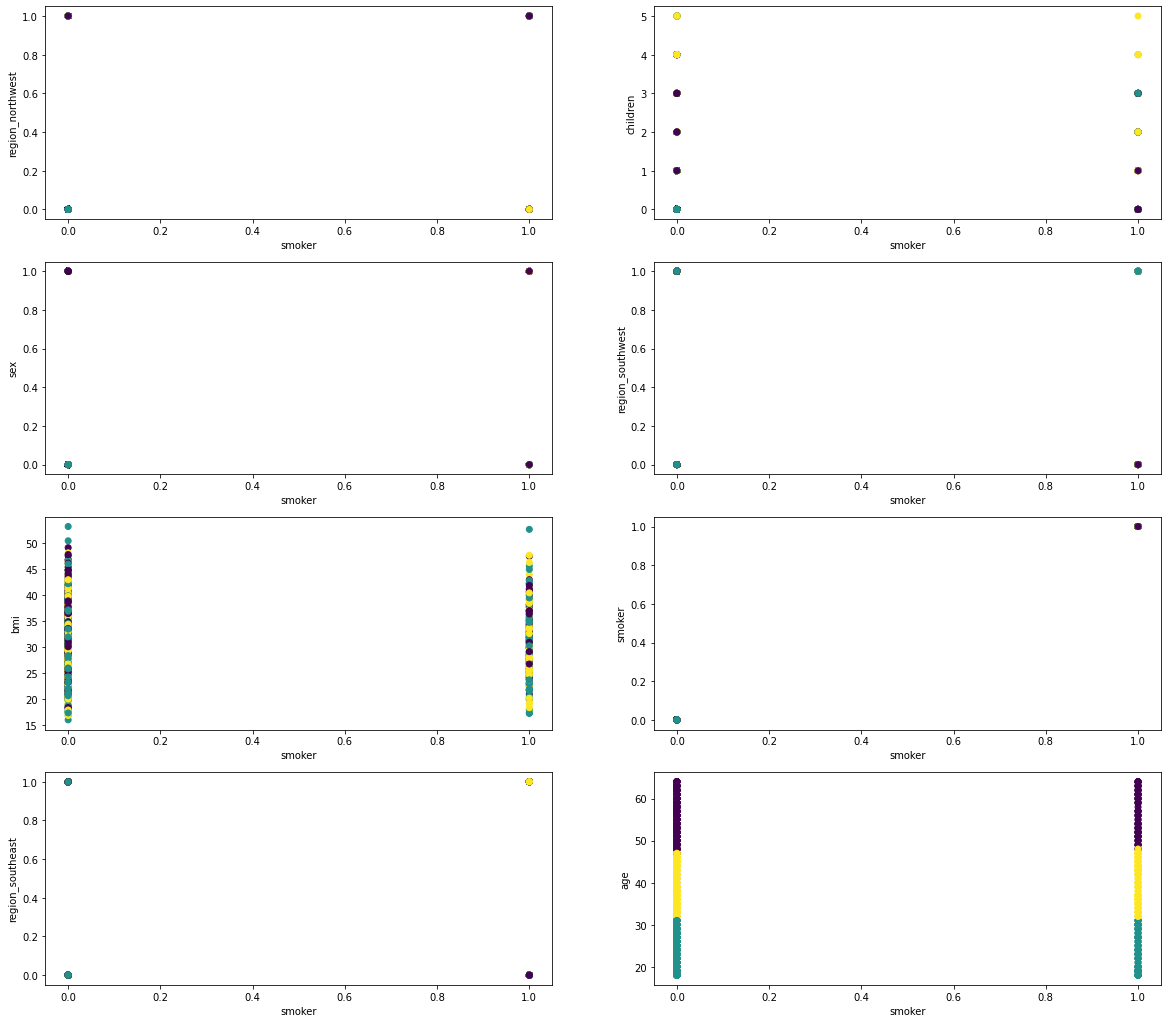

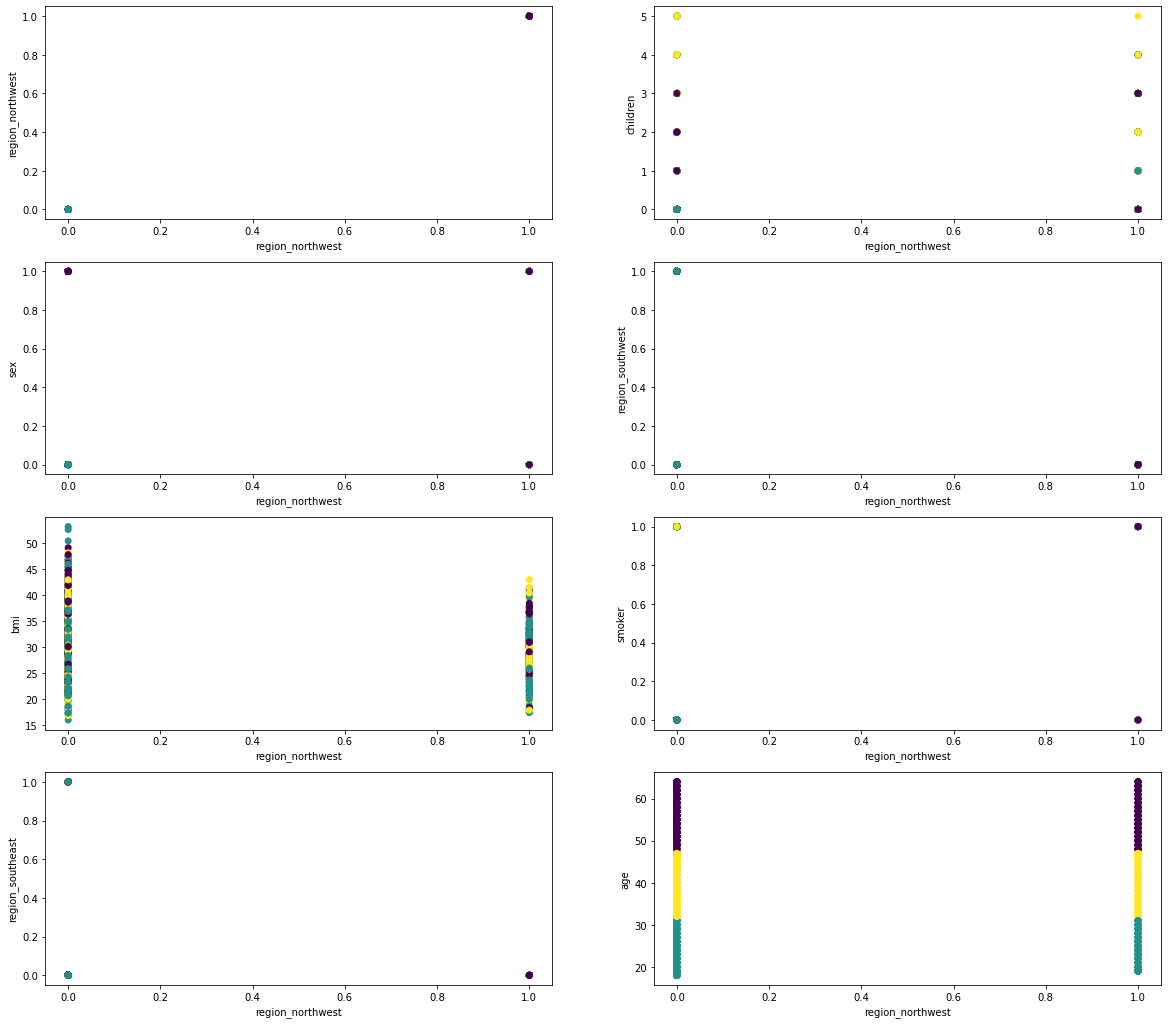

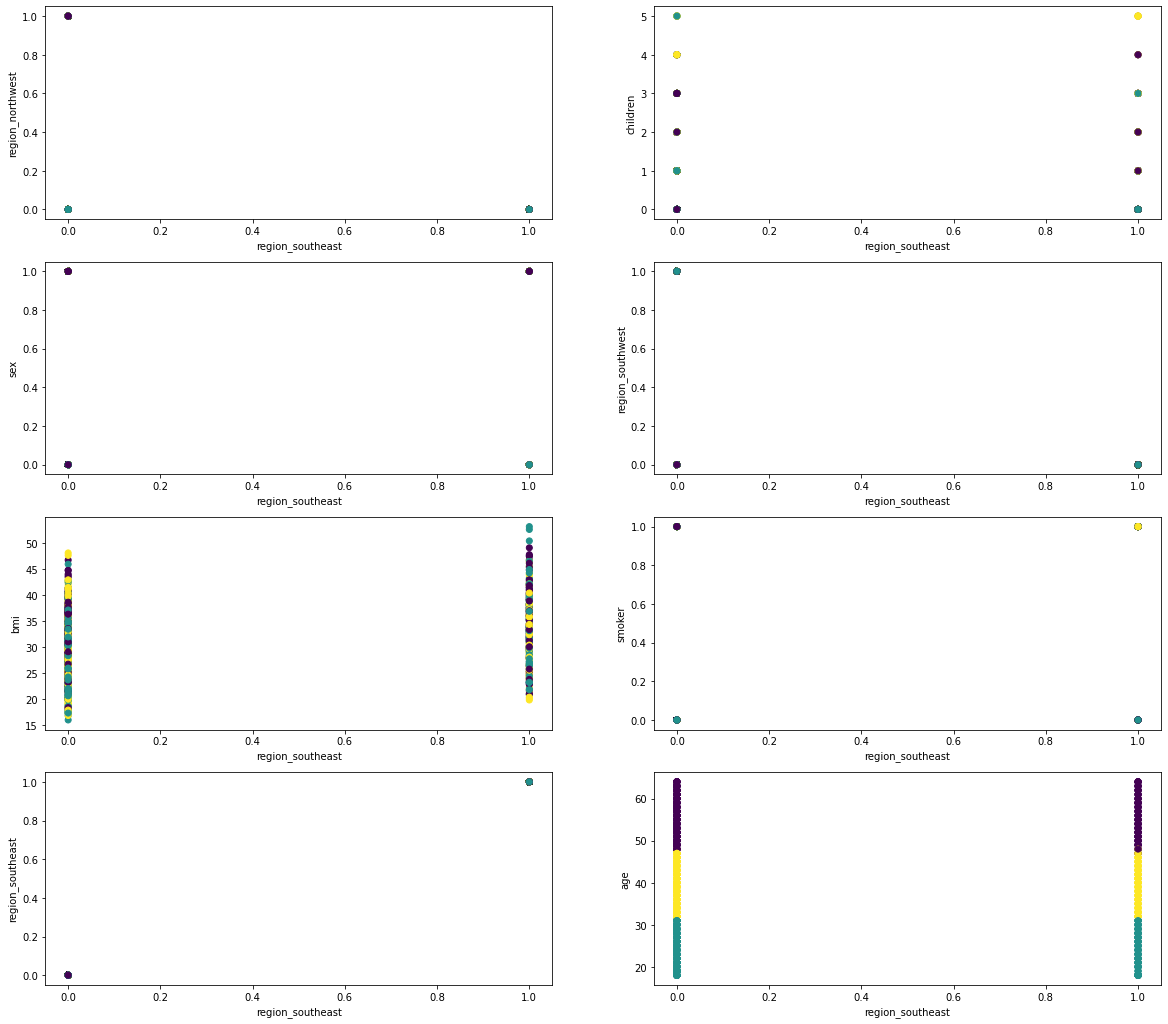

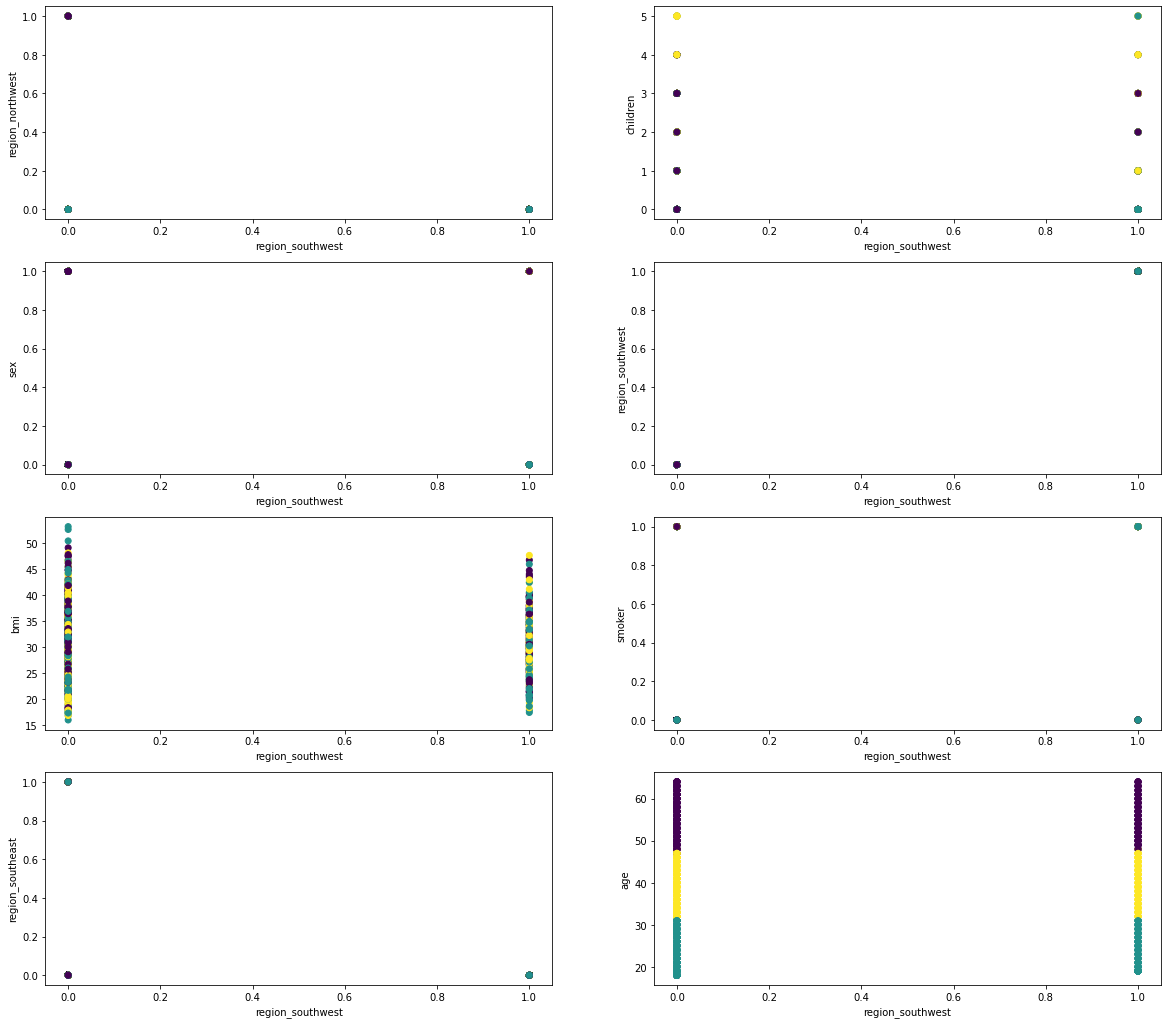

In [84]:
for col in X.columns:
    clustering(X,col,cluster)

### Analysis
    - age is forming clusters with all the features

In [85]:
new_df = df.join(pd.DataFrame(cluster,columns=['clusters']),how='left')
new_df.head()

,age,sex,bmi,children,smoker,region_northwest,region_southeast,region_southwest,charges in INR,clusters
0,19,0,27.900,0,1,0,0,1,16884.92400,1
1,18,1,33.770,1,0,0,1,0,1725.55230,1
2,28,1,33.000,3,0,0,1,0,4449.46200,1
3,33,1,22.705,0,0,1,0,0,21984.47061,2
4,32,1,28.880,0,0,1,0,0,3866.85520,2


In [86]:
new_df1 = df1.join(pd.DataFrame(cluster,columns=['clusters']),how='left')
new_df1.head()

,age,sex,bmi_bins,children,smoker,region_northwest,region_southeast,region_southwest,charges in INR,clusters
0,19,0,4,0,1,0,0,1,16884.92400,1
1,18,1,5,1,0,0,1,0,1725.55230,1
2,28,1,5,3,0,0,1,0,4449.46200,1
3,33,1,2,0,0,1,0,0,21984.47061,2
4,32,1,4,0,0,1,0,0,3866.85520,2


In [87]:
temp_df = new_df.groupby('clusters')['age'].agg(['mean','median'])
temp_df.head()

,mean,median
clusters,,
0,55.569161,55.0
1,23.422505,23.0
2,39.720657,40.0


In [88]:
temp_df1 = new_df1.groupby('clusters')['age'].agg(['mean','median'])
temp_df1.head()

,mean,median
clusters,,
0,55.569161,55.0
1,23.422505,23.0
2,39.720657,40.0


In [89]:
cluster_df = new_df.merge(temp_df,on= 'clusters',how='left')
cluster_df.head()

,age,sex,bmi,children,smoker,region_northwest,region_southeast,region_southwest,charges in INR,clusters,mean,median
0,19,0,27.900,0,1,0,0,1,16884.92400,1,23.422505,23.0
1,18,1,33.770,1,0,0,1,0,1725.55230,1,23.422505,23.0
2,28,1,33.000,3,0,0,1,0,4449.46200,1,23.422505,23.0
3,33,1,22.705,0,0,1,0,0,21984.47061,2,39.720657,40.0
4,32,1,28.880,0,0,1,0,0,3866.85520,2,39.720657,40.0


In [90]:
cluster_df1 = new_df1.merge(temp_df,on= 'clusters',how='left')
cluster_df1.head()

,age,sex,bmi_bins,children,smoker,region_northwest,region_southeast,region_southwest,charges in INR,clusters,mean,median
0,19,0,4,0,1,0,0,1,16884.92400,1,23.422505,23.0
1,18,1,5,1,0,0,1,0,1725.55230,1,23.422505,23.0
2,28,1,5,3,0,0,1,0,4449.46200,1,23.422505,23.0
3,33,1,2,0,0,1,0,0,21984.47061,2,39.720657,40.0
4,32,1,4,0,0,1,0,0,3866.85520,2,39.720657,40.0


In [91]:
X = cluster_df.drop(['charges in INR','clusters'],axis=1)
y = cluster_df['charges in INR']

In [92]:
X1 = cluster_df.drop(['charges in INR','clusters'],axis=1)
y1 = cluster_df['charges in INR']

### Clusters in df

In [93]:
multiple_models(cluster_df,cluster_df,'charges in INR')

,Model_Name,R2 Score,RMSE
0,Gradient Boost regressor,0.853015,4368.891493
1,Adaboost regressor,0.825531,4759.850890
2,Random Forest regressor,0.820553,4827.281479
3,XGBoost regressor,0.759188,5592.080132
4,Ridge regression,0.720654,6022.899357
5,Lasso regression,0.720037,6029.546197
6,Linear regression,0.719997,6029.978175
7,Decision Tree regressor,0.690004,6344.717175
8,K Neighbors regressor,0.099069,10816.332691
9,Support Vector regressor,-0.093126,11914.318480


In [94]:
kfold_cv(cluster_df,cluster_df,'charges in INR')

,Model Name,R2 Score,Score Std Deviation
0,GradientBoostingRegressor,0.855847,0.044674
1,RandomForestRegressor,0.834452,0.043306
2,AdaBoostRegressor,0.819928,0.031215
3,XGBRegressor,0.805939,0.061674
4,Ridge,0.746399,0.040654
5,Lasso,0.746386,0.041015
6,LinearRegression,0.746335,0.041098
7,DecisionTreeRegressor,0.683882,0.070927
8,KNeighborsRegressor,0.149276,0.087465
9,SVR,-0.105956,0.030927


In [95]:
CV_post_hpt(X,y,X,y)

,model names,R2 Mean,R2 Std
0,Gradient Boosting Regressor,0.856303,0.045302
1,AdaBoost Regressor,0.847019,0.047294
2,XGB Regressor,0.835269,0.048511
3,Random Forest Regressor,0.834963,0.041297
4,Linear Regression,0.746379,0.041034
5,Ridge,0.746264,0.039638
6,Lasso,0.745964,0.041919
7,Decision Tree Regressor,0.622409,0.127937
8,KNeighbors Regressor,0.159688,0.060934
9,SVR,-0.105968,0.030944


### Clusters in df1

In [96]:
multiple_models(cluster_df1,cluster_df1,'charges in INR')

,Model_Name,R2 Score,RMSE
0,Gradient Boost regressor,0.849297,4423.793279
1,Random Forest regressor,0.811481,4947.794885
2,Adaboost regressor,0.805339,5027.743405
3,XGBoost regressor,0.764986,5524.347439
4,Ridge regression,0.721502,6013.752358
5,Lasso regression,0.720966,6019.532555
6,Linear regression,0.720933,6019.885385
7,Decision Tree regressor,0.642022,6818.082404
8,K Neighbors regressor,0.292683,9583.873328
9,Support Vector regressor,-0.093248,11914.984747


In [97]:
kfold_cv(cluster_df1,cluster_df1,'charges in INR')

,Model Name,R2 Score,Score Std Deviation
0,GradientBoostingRegressor,0.855006,0.045873
1,RandomForestRegressor,0.821543,0.042808
2,XGBRegressor,0.794550,0.047560
3,Ridge,0.744842,0.036474
4,Lasso,0.744828,0.036813
5,LinearRegression,0.744794,0.036840
6,AdaBoostRegressor,0.734970,0.061248
7,DecisionTreeRegressor,0.698999,0.052255
8,KNeighborsRegressor,0.371092,0.054764
9,SVR,-0.106058,0.031015


In [98]:
CV_post_hpt(X1,y1,X1,y1)

,model names,R2 Mean,R2 Std
0,Gradient Boosting Regressor,0.856130,0.045164
1,AdaBoost Regressor,0.846987,0.045660
2,Random Forest Regressor,0.835471,0.040614
3,XGB Regressor,0.835269,0.048511
4,Linear Regression,0.746379,0.041034
5,Ridge,0.746264,0.039638
6,Lasso,0.745964,0.041919
7,Decision Tree Regressor,0.641588,0.087412
8,KNeighbors Regressor,0.159688,0.060934
9,SVR,-0.105968,0.030944


## Feature importance using XGBoost

### Feature importance in df

In [99]:
X_train,X_test,y_train,y_test = train_and_test_split(cluster_df.drop('clusters',axis=1),'charges in INR')

In [100]:
xgb = XGBRegressor()

In [101]:
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

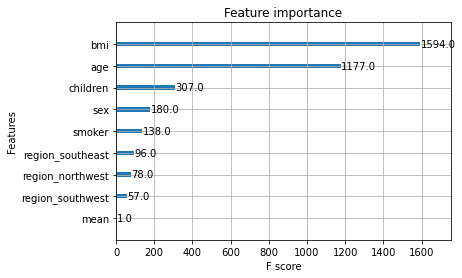

In [102]:
xgboost.plot_importance(xgb)

In [103]:
f_df = cluster_df[['bmi','age','children','sex','smoker','region_southeast','charges in INR']]
f_df.head()

,bmi,age,children,sex,smoker,region_southeast,charges in INR
0,27.900,19,0,0,1,0,16884.92400
1,33.770,18,1,1,0,1,1725.55230
2,33.000,28,3,1,0,1,4449.46200
3,22.705,33,0,1,0,0,21984.47061
4,28.880,32,0,1,0,0,3866.85520


In [104]:
CV_post_hpt(f_df.drop('charges in INR',axis=1),f_df['charges in INR'],
            f_df.drop('charges in INR',axis=1),f_df['charges in INR'])

,model names,R2 Mean,R2 Std
0,Gradient Boosting Regressor,0.856061,0.044460
1,AdaBoost Regressor,0.847882,0.046198
2,XGB Regressor,0.830410,0.051755
3,Random Forest Regressor,0.829342,0.041726
4,Lasso,0.744314,0.043528
5,Linear Regression,0.744284,0.043674
6,Ridge,0.744158,0.042145
7,Decision Tree Regressor,0.626724,0.135936
8,KNeighbors Regressor,0.156296,0.057918
9,SVR,-0.104926,0.030707


### Feature importance in df1 (binned)

In [105]:
X_train1,X_test1,y_train1,y_test1 = train_and_test_split(cluster_df1.drop('clusters',axis=1),'charges in INR')

In [106]:
xgb1 = XGBRegressor()

In [107]:
xgb1.fit(X_train1,y_train1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

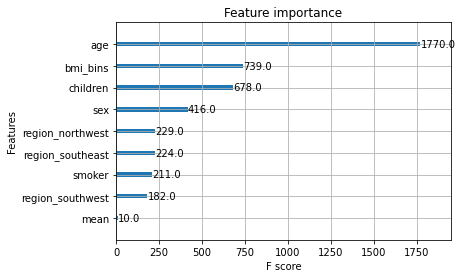

In [108]:
xgboost.plot_importance(xgb1)

In [109]:
f_df1 = cluster_df1[['bmi_bins','age','children','sex','smoker','region_southeast','region_northwest',
                     'charges in INR']]
f_df1.head()

,bmi_bins,age,children,sex,smoker,region_southeast,region_northwest,charges in INR
0,4,19,0,0,1,0,0,16884.92400
1,5,18,1,1,0,1,0,1725.55230
2,5,28,3,1,0,1,0,4449.46200
3,2,33,0,1,0,0,1,21984.47061
4,4,32,0,1,0,0,1,3866.85520


In [110]:
CV_post_hpt(f_df1.drop('charges in INR',axis=1),f_df1['charges in INR'],f_df1.drop('charges in INR',axis=1),
            f_df1['charges in INR'])

,model names,R2 Mean,R2 Std
0,Gradient Boosting Regressor,0.853746,0.045200
1,AdaBoost Regressor,0.846071,0.048992
2,XGB Regressor,0.835002,0.045921
3,Random Forest Regressor,0.822392,0.039196
4,Lasso,0.742742,0.039253
5,Linear Regression,0.742672,0.039397
6,Ridge,0.742552,0.037960
7,Decision Tree Regressor,0.629596,0.091605
8,KNeighbors Regressor,0.388831,0.068549
9,SVR,-0.104856,0.030923


### RFE

### RFE in df

In [111]:
rfe = RFE(xgb)

In [112]:
rfe.fit(X_train,y_train)

RFE(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                           colsample_bylevel=1, colsample_bynode=1,
                           colsample_bytree=1, enable_categorical=False,
                           gamma=0, gpu_id=-1, importance_type=None,
                           interaction_constraints='',
                           learning_rate=0.300000012, max_delta_step=0,
                           max_depth=6, min_child_weight=1, missing=nan,
                           monotone_constraints='()', n_estimators=100,
                           n_jobs=8, num_parallel_tree=1, predictor='auto',
                           random_state=0, reg_alpha=0, reg_lambda=1,
                           scale_pos_weight=1, subsample=1, tree_method='exact',
                           validate_parameters=1, verbosity=None))

In [113]:
rfe.support_

array([ True, False,  True, False,  True,  True, False,  True, False,
       False])

In [114]:
X_train.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region_northwest',
       'region_southeast', 'region_southwest', 'mean', 'median'],
      dtype='object')

In [115]:
rfe_df = cluster_df[['age','bmi','smoker','region_northwest','region_southwest','charges in INR']]
rfe_df.head()

,age,bmi,smoker,region_northwest,region_southwest,charges in INR
0,19,27.900,1,0,1,16884.92400
1,18,33.770,0,0,0,1725.55230
2,28,33.000,0,0,0,4449.46200
3,33,22.705,0,1,0,21984.47061
4,32,28.880,0,1,0,3866.85520


In [116]:
CV_post_hpt(rfe_df.drop('charges in INR',1),rfe_df['charges in INR'],
            rfe_df.drop('charges in INR',1),rfe_df['charges in INR'])

,model names,R2 Mean,R2 Std
0,Gradient Boosting Regressor,0.851393,0.046388
1,AdaBoost Regressor,0.845013,0.046716
2,XGB Regressor,0.829804,0.048169
3,Random Forest Regressor,0.815407,0.045247
4,Lasso,0.742905,0.039587
5,Linear Regression,0.742902,0.039640
6,Ridge,0.742775,0.038162
7,Decision Tree Regressor,0.704996,0.065217
8,KNeighbors Regressor,0.189520,0.050105
9,SVR,-0.104881,0.030732


### RFE in df1

In [117]:
rfe1 = RFE(xgb1)

In [118]:
rfe1.fit(X_train1,y_train1)

RFE(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                           colsample_bylevel=1, colsample_bynode=1,
                           colsample_bytree=1, enable_categorical=False,
                           gamma=0, gpu_id=-1, importance_type=None,
                           interaction_constraints='',
                           learning_rate=0.300000012, max_delta_step=0,
                           max_depth=6, min_child_weight=1, missing=nan,
                           monotone_constraints='()', n_estimators=100,
                           n_jobs=8, num_parallel_tree=1, predictor='auto',
                           random_state=0, reg_alpha=0, reg_lambda=1,
                           scale_pos_weight=1, subsample=1, tree_method='exact',
                           validate_parameters=1, verbosity=None))

In [119]:
rfe1.support_

array([ True, False,  True,  True,  True,  True, False, False, False,
       False])

In [120]:
X_train1.columns

Index(['age', 'sex', 'bmi_bins', 'children', 'smoker', 'region_northwest',
       'region_southeast', 'region_southwest', 'mean', 'median'],
      dtype='object')

In [121]:
rfe_df1 = cluster_df1[['age','bmi_bins','children','smoker','region_northwest','charges in INR']]
rfe_df1.head()

,age,bmi_bins,children,smoker,region_northwest,charges in INR
0,19,4,0,1,0,16884.92400
1,18,5,1,0,0,1725.55230
2,28,5,3,0,0,4449.46200
3,33,2,0,0,1,21984.47061
4,32,4,0,0,1,3866.85520


In [122]:
CV_post_hpt(rfe_df1.drop('charges in INR',1),rfe_df1['charges in INR'],
            rfe_df1.drop('charges in INR',1),rfe_df1['charges in INR'])

,model names,R2 Mean,R2 Std
0,Gradient Boosting Regressor,0.855052,0.043745
1,AdaBoost Regressor,0.846438,0.045654
2,XGB Regressor,0.835877,0.041147
3,Random Forest Regressor,0.817786,0.036700
4,Lasso,0.743374,0.038689
5,Linear Regression,0.743342,0.038759
6,Ridge,0.743227,0.037394
7,Decision Tree Regressor,0.739703,0.049262
8,KNeighbors Regressor,0.448317,0.033422
9,SVR,-0.104839,0.030967


## Learning curve analysis

In [123]:
def generate_learning_curve(model_name,estimator,X,y,cv=10):
    train_size,train_score,test_score = learning_curve(estimator=estimator,X=X,y=y,cv=cv)
    train_score_mean = np.mean(train_score,axis=1)
    test_score_mean = np.mean(test_score,axis=1)
    plt.plot(train_size,train_score_mean,c='blue')
    plt.plot(train_size,test_score_mean,c='red')   
    plt.xlabel('Samples')
    plt.ylabel('Accuracy')
    plt.title('Learning curve for '+model_name)
    plt.legend(('Training_accuracy','Testing_accuracy'))

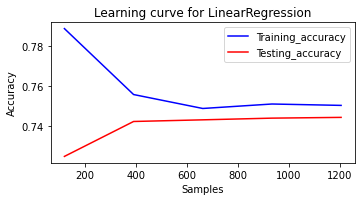

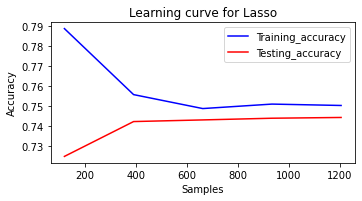

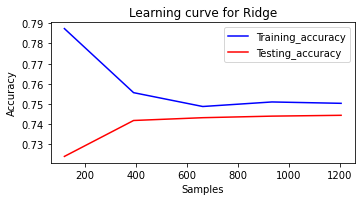

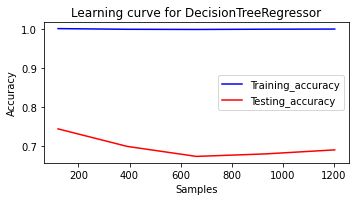

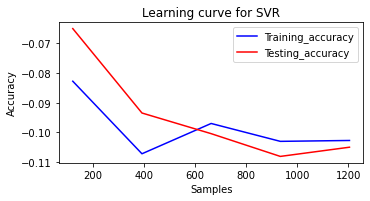

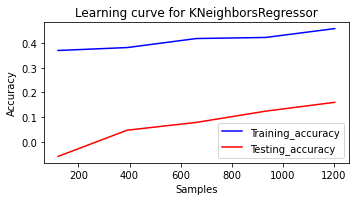

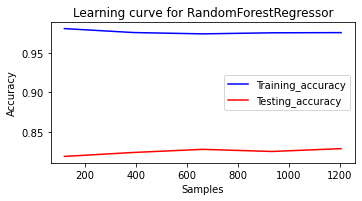

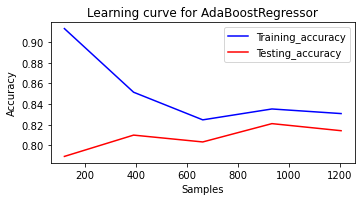

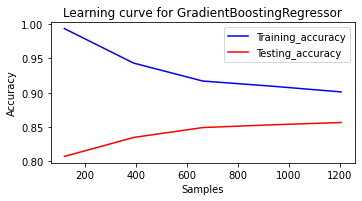

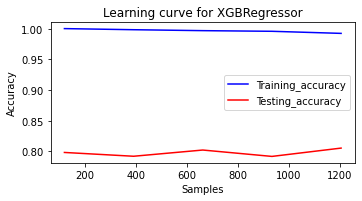

In [124]:
model_names = [LinearRegression(),Lasso(),Ridge(),DecisionTreeRegressor(),SVR(),KNeighborsRegressor(),
               RandomForestRegressor(),AdaBoostRegressor(),GradientBoostingRegressor(),XGBRegressor()]
for a ,model in enumerate(model_names):
    fg = plt.figure(figsize=(12,15))
    ax = fg.add_subplot(5,2,a+1)
    generate_learning_curve(type(model_names[a]).__name__,model,f_df.drop('charges in INR',1),f_df['charges in INR'])

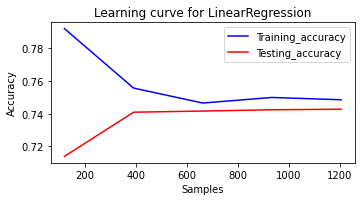

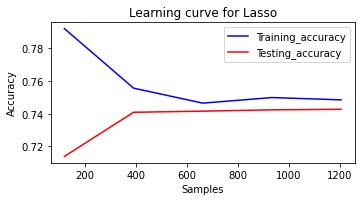

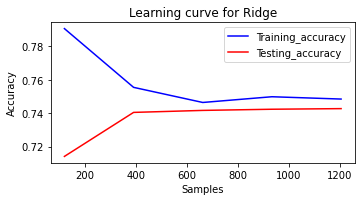

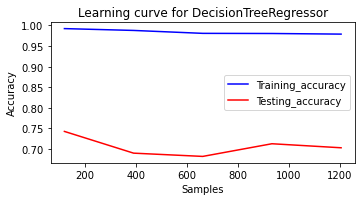

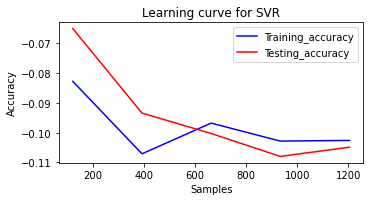

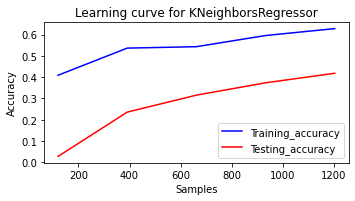

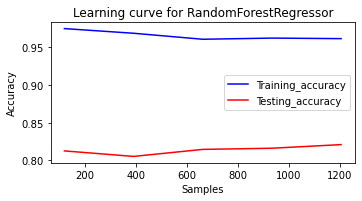

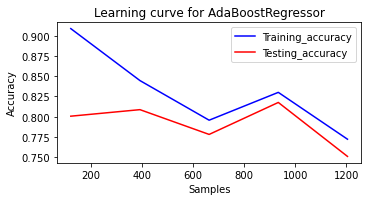

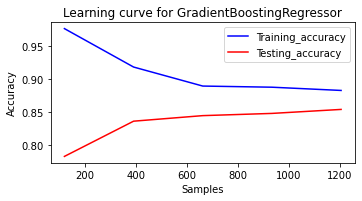

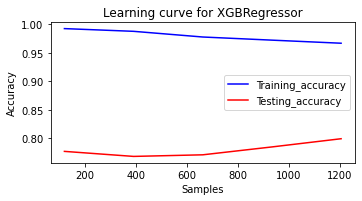

In [125]:
model_names = [LinearRegression(),Lasso(),Ridge(),DecisionTreeRegressor(),SVR(),KNeighborsRegressor(),
               RandomForestRegressor(),AdaBoostRegressor(),GradientBoostingRegressor(),XGBRegressor()]
for a ,model in enumerate(model_names):
    fg = plt.figure(figsize=(12,15))
    ax = fg.add_subplot(5,2,a+1)
    generate_learning_curve(type(model_names[a]).__name__,model,f_df1.drop('charges in INR',1),f_df1['charges in INR'])